<a href="https://colab.research.google.com/github/anandmali/Movies_Recommenders/blob/main/ranking_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Imports

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 26.2 MB/s eta 0:00:00


In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt

plt.style.use('ggplot')


####Preparing data

In [3]:
ratings = tfds.load("movielens/100k-ratings", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incomplete11XWZD/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


In [4]:
#Shuffle
tf.random.set_seed(42)
shuffledd = ratings.shuffle(100_00, seed = 42, reshuffle_each_iteration = False)

l = len(ratings)

train_ = int(0.75 * l)
test_ = int(0.25 * l)

##Split for traingin and testing
train = shuffledd.take(train_)
test = shuffledd.skip(train_).take(test_)


In [5]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

#### Implementing a model

Ranking models do not face the same efficiency constraints as retrieval models do, and so we have a little bit more freedom in our choice of architectures.

A model composed of multiple stacked dense layers is a relatively common architecture for ranking tasks. We can implement it as follows:

In [6]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [7]:
RankingModel()((["34"], ["Scream 2 (1997)"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01173562]], dtype=float32)>

In [8]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [9]:
class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [10]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [11]:
cached_train = train.shuffle(100_000).batch(8192).cache()
# cached_test = test.batch(4096).cache()

In [ ]:
# model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 7s 328ms/step - root_mean_squared_error: 2.1143 - loss: 3.9542 - regularization_loss: 0.0000e+00 - total_loss: 3.9542 - val_root_mean_squared_error: 1.2272 - val_loss: 1.5739 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.5739
Epoch 2/3
10/10 [==============================] - 0s 45ms/step - root_mean_squared_error: 1.1975 - loss: 1.4131 - regularization_loss: 0.0000e+00 - total_loss: 1.4131 - val_root_mean_squared_error: 1.1554 - val_loss: 1.3761 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3761
Epoch 3/3
10/10 [==============================] - 0s 43ms/step - root_mean_squared_error: 1.1291 - loss: 1.2663 - regularization_loss: 0.0000e+00 - total_loss: 1.2663 - val_root_mean_squared_error: 1.1139 - val_loss: 1.2571 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2571


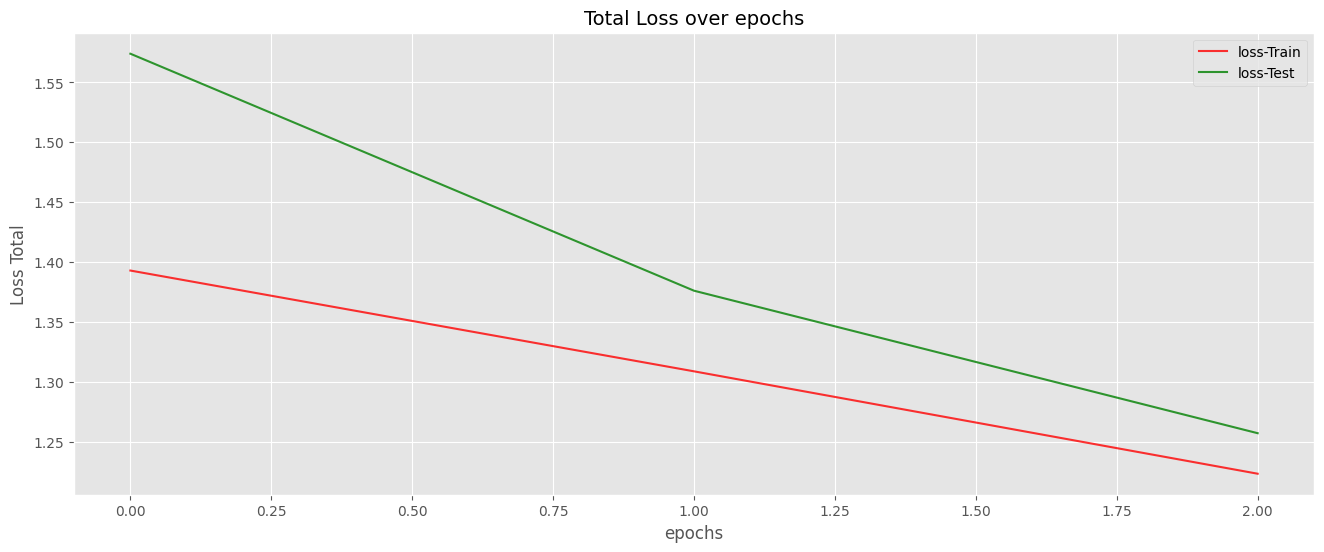

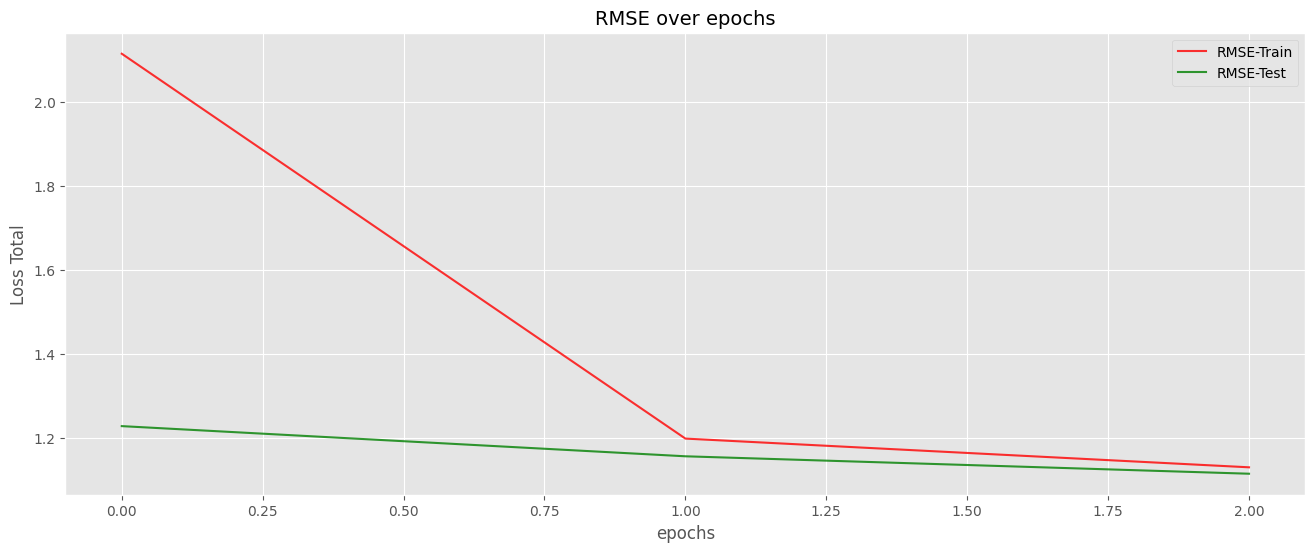

In [12]:

# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch,
# while having a batch size which is a multiple of 2^n.
# cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

# Then, let's train the model:
history_train = model.fit(cached_train, validation_data = cached_test, epochs=3)

plt.subplots(figsize = (16,6))
plt.plot(history_train.history['total_loss'],color='red', alpha=0.8, label='loss-Train')
plt.plot(history_train.history['val_total_loss'],color='green', alpha=0.8, label='loss-Test')
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

plt.subplots(figsize = (16,6))
plt.plot(history_train.history['root_mean_squared_error'],color='red', alpha=0.8, label='RMSE-Train')
plt.plot(history_train.history['val_root_mean_squared_error'],color='green', alpha=0.8, label='RMSE-Test')
plt.title("RMSE over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [13]:
model.evaluate(cached_test, return_dict=True)

13/13 [==============================] - 0s 3ms/step - root_mean_squared_error: 1.1139 - loss: 1.2428 - regularization_loss: 0.0000e+00 - total_loss: 1.2428


{'root_mean_squared_error': 1.113860011100769,
 'loss': 1.2571266889572144,
 'regularization_loss': 0,
 'total_loss': 1.2571266889572144}

In [14]:
test_ratings = {}
test_movie_titles = ["Glengarry Glen Ross (1992)",
                     "Cold Comfort Farm (1995)",
                     "Man Without a Face, The (1993)",
                     "Heathers (1989)",
                     "Mulholland Falls (1996)",
                     "Sphere (1998)",
                     "Secrets & Lies (1996)",
                     "Tin Men (1987)",
                     "One Flew Over the Cuckoo's Nest (1975"]
for movie_title in test_movie_titles:
  test_ratings[movie_title] = model({
      "user_id": np.array(["12"]),
      "movie_title": np.array([movie_title])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
Heathers (1989): [[3.5248437]]
Mulholland Falls (1996): [[3.5184488]]
Tin Men (1987): [[3.5012991]]
Secrets & Lies (1996): [[3.4959564]]
Cold Comfort Farm (1995): [[3.4857106]]
One Flew Over the Cuckoo's Nest (1975: [[3.4527125]]
Sphere (1998): [[3.4435437]]
Glengarry Glen Ross (1992): [[3.4263186]]
Man Without a Face, The (1993): [[3.4092305]]
